In [15]:
# exercise 13.9
#下载 Large Movie Review Dataset，它包含 50000 条 IMDB 的影评。数据分为两个目录，train和test，
#每个包含 12500 条正面评价和 12500 条负面评价。每条评价都存在独立的文本文件中。

import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
from tensorflow.keras import layers
from tensorflow.keras import losses

In [17]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

#获取目录结构
os.listdir(dataset_dir)


['imdbEr.txt', 'imdb.vocab', 'test', 'train', 'README']

In [18]:
#train目录结构
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['labeledBow.feat',
 'neg',
 'unsupBow.feat',
 'urls_pos.txt',
 'pos',
 'urls_neg.txt',
 'urls_unsup.txt',
 'unsup']

In [19]:
#随机读取一条评论
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
    print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [20]:

# 正面负面评论分别位于  aclImdb/train/pos 和 aclImdb/train/neg
# 删除unsup 
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)


In [21]:
#没有unsup文件夹了
os.listdir(train_dir)

['labeledBow.feat',
 'neg',
 'unsupBow.feat',
 'urls_pos.txt',
 'pos',
 'urls_neg.txt',
 'urls_unsup.txt']

In [22]:
#文件夹有train test数据集，缺少valid数据集
#通过validation_split 参数，使用 80:20 拆分训练数据来创建验证集。
#使用 text_dataset_from_directory 工具进行二元分类，不同文件夹的文本即对应不同标签
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir, 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [17]:
#取一批raw_train 数据（32个），打印三个
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print("Review", text_batch.numpy()[i])
        print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

In [23]:
#通过文件名和label名，确定label 0 表示 neg，label 1 表示 pos
raw_train_ds.class_names

['neg', 'pos']

In [24]:
#取验证集,确保和之前获取训练集函数使用一样的seed
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir, 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [25]:
#测试集 25000个
test_dir=os.path.join(dataset_dir,"test")
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    test_dir, 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


In [26]:
# 使用tf.keras.layers.TextVectorization 层对数据进行标准化、词例化和向量化
# 为在训练和测试时间对数据进行相同的预处理，将 TextVectorization 层直接包含在模型中
# 定义标准输入函数，处理大小写和换行符

def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data) #小写处理
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ') #把<br /> 替换为空格
    return tf.strings.regex_replace(stripped_html,
                                    '[%s]' % re.escape(string.punctuation),'')

#最后一行表示将所有标点符号正则转译为空符号

In [27]:
#创建一个 TextVectorization 层，该层对我们的数据进行标准化、词例化和向量化。
#调用了之前定义的标准化函数
#将 output_mode 设置为 int 以便为每个词例创建唯一的整数索引。

max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [28]:
#调用 adapt 以使预处理层的状态适合数据集。使模型构建字符串到整数的索引。
#对raw_train_ds 做map，去除标签
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [29]:
#创建一个函数来查看使用该层预处理一些数据的结果
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1) #原始数据加一个维度
    return vectorize_layer(text), label #多出来的维度就是label

#每次执行下一个batch ，32个review加label
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])


Review tf.Tensor(b"The 60\xc2\xb4s is a well balanced mini series between historical facts and a good plot. In four deliveries, we follow a north American family, with 3 members. But we don't only see them. We also follow the story of several characters as a black reverend, an extremist student leader, and a soldier in Vietnam. The filmography is just extraordinary. In the first chapters, we see some shots of the Vietnam war, in between the scenes. The next chapter, doesn't start where the last one finished, it starts some time after, giving us a little mystery on what happened. In general, The 60\xc2\xb4s mini series, is a must see, not only for hippies fanatics, but for everyone with little curiosity about the topic.", shape=(), dtype=string)
Label pos


In [30]:
print("Vectorized review", vectorize_text(first_review, first_label))

Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[   2,    1,    7,    4,   73, 7844, 4199,  200,  188, 1397, 2232,
           3,    4,   49,  111,    8,  695,    1,   71,  821,    4, 2324,
         312,  215,   16,  452, 1038,   18,   71,   89,   61,   67,   93,
          71,   77,  821,    2,   63,    5,  440,  100,   14,    4,  321,
           1,   33,    1, 1528, 2032,    3,    4, 1560,    8, 2503,    2,
        7382,    7,   40, 2735,    8,    2,   83, 9141,   71,   67,   46,
         647,    5,    2, 2503,  329,    8,  188,    2,  136,    2,  357,
        4745,  144,  368,  114,    2,  229,   28, 1752,    9,  501,   46,
          58,  101,  725,  167,    4,  112,  743,   20,   48,  553,    8,
         776,    2,    1, 4199,  200,    7,    4,  219,   67,   21,   61,
          15, 6115, 9349,   18,   15,  302,   16,  112, 3496,   42,    2,
        2936,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,  

In [31]:
#该层上调用 .get_vocabulary() 来查找每个整数对应的词例（字符串）
vectorize_layer.get_vocabulary()[1287]

'silent'

In [32]:
#一共一万个词汇，对应vectorize_layer 的max_feature
len(vectorize_layer.get_vocabulary())

10000

In [33]:
#转换训练集，验证集，测试集

train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [34]:
#加buffersize，将数据保存在可用内存中

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [35]:
#创建模型
#Embedding 层。此层采用整数编码的评论，并查找每个单词索引的嵌入向量。
#这些向量是通过模型训练学习到的。向量向输出数组增加了一个维度
#得到的维度为：(batch, sequence, embedding)

#GlobalAveragePooling1D 将通过对序列维度求平均值来为每个样本返回一个定长输出向量
#这允许模型以尽可能最简单的方式处理变长输入

embedding_dim = 16
model = tf.keras.Sequential([
    layers.Embedding(max_features + 1, embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(1)
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160033 (625.13 KB)
Trainable params: 160033 (625.13 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [39]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
 
optimizer = keras.optimizers.Nadam()

model.compile(loss=losses.BinaryCrossentropy(from_logits=False), #二元交叉熵
              optimizer=optimizer,
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))
    
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_binary_accuracy",patience=10,restore_best_weights=True)

callbacks = [early_stopping_cb]

epochs = 100
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs, callbacks=callbacks)

Epoch 1/100
625/625 [==============================] - 36s 56ms/step - loss: 0.1575 - binary_accuracy: 0.8467 - val_loss: 0.5682 - val_binary_accuracy: 0.8132
Epoch 2/100
625/625 [==============================] - 9s 15ms/step - loss: 0.1529 - binary_accuracy: 0.8632 - val_loss: 0.6082 - val_binary_accuracy: 0.8090
Epoch 3/100
625/625 [==============================] - 9s 15ms/step - loss: 0.1426 - binary_accuracy: 0.8724 - val_loss: 0.6572 - val_binary_accuracy: 0.8124
Epoch 4/100
625/625 [==============================] - 10s 15ms/step - loss: 0.1317 - binary_accuracy: 0.8773 - val_loss: 0.6930 - val_binary_accuracy: 0.8226
Epoch 5/100
625/625 [==============================] - 10s 15ms/step - loss: 0.1305 - binary_accuracy: 0.8816 - val_loss: 0.7276 - val_binary_accuracy: 0.8214
Epoch 6/100
625/625 [==============================] - 10s 15ms/step - loss: 0.1271 - binary_accuracy: 0.8888 - val_loss: 0.7420 - val_binary_accuracy: 0.8272
Epoch 7/100
625/625 [===========================

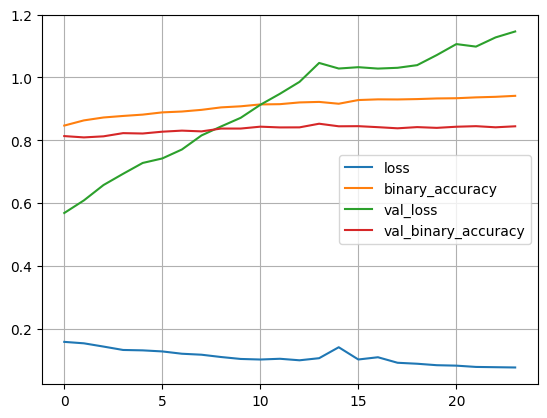

782/782 - 4s - loss: 1.2411 - binary_accuracy: 0.8349 - 4s/epoch - 5ms/step


[1.2410783767700195, 0.8349199891090393]

In [40]:
pd.DataFrame(history.history).plot() 
plt.grid(True)
plt.show()
model.evaluate(test_ds,verbose=2)

In [41]:
#原有模型基础上，改造为能直接处理原始字符的模型
#将vectorize_layer加入原有模型的最上层

export_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    layers.Activation('sigmoid')
])


# bce 概率值值域范围 [0, 1]
#则应该设置为 from_logits=False，否则设置为True

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="nadam", metrics=['accuracy']
)

# 直接评估，无需拟合，使用raw数据集
export_model.evaluate(raw_test_ds)


782/782 [==============================] - 6s 8ms/step - loss: 0.4075 - accuracy: 0.8349


[0.407532274723053, 0.8349199891090393]

In [43]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

1/1 [==============================] - 0s 31ms/step


array([[0.64414287],
       [0.56766653],
       [0.54935235]], dtype=float32)

## TF HUB

In [3]:
#用TF_hub 处理embedding 

import os
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

/tmp/tf-venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

GPU is available


2024-05-09 19:16:09.668513: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-09 19:16:10.928714: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-09 19:16:10.929886: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [5]:
#使用标准数据集

train_data, validation_data, test_data = tfds.load(
    name="imdb_reviews", 
    split=('train[:60%]', 'train[60%:]', 'test'),
    as_supervised=True)

2024-05-09 19:16:16.093878: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-09 19:16:16.094754: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-09 19:16:16.095639: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-09 19:16:20.546849: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-09 19:16:20.547629: I external/local_xla/xla/stream_executor

In [6]:
train_examples_batch, train_labels_batch = next(iter(train_data.batch(10)))
train_labels_batch

AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
validation_data = validation_data.cache().prefetch(buffer_size=AUTOTUNE)
test_data = test_data.cache().prefetch(buffer_size=AUTOTUNE)

google/nnlm-en-dim50/2 可将句子拆分为词例，嵌入每个词例，然后组合嵌入向量

google/nnlm-en-dim128/2 - 基于与 google/nnlm-en-dim50/2 相同的数据并使用相同的 NNLM 架构进行训练，但具有更大的嵌入向量维度。

google/nnlm-en-dim128-with-normalization/2 - 与 google/nnlm-en-dim128/2 相同，但具有额外的文本归一化，例如移除标点符号。如果文本包含附加字符或标点符号，这会有所帮助。

google/universal-sentence-encoder/4 - 一个可产生 512 维嵌入向量的大得多的模型，使用深度平均网络 (DAN) 编码器训练。

embeding更大维度的嵌入向量可以改进任务，但可能需要更长的时间来训练模型。

In [8]:
embedding = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)
hub_layer(train_examples_batch[:3]) #输出前三个训练集对应的向量

2024-05-09 19:17:33.046073: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


<tf.Tensor: shape=(3, 128), dtype=float32, numpy=
array([[ 1.15015066e+00,  7.80130103e-02,  9.26615447e-02,
         2.83361435e-01,  9.67164431e-03, -1.49186060e-01,
         3.35665733e-01, -3.50244790e-01, -8.28830618e-03,
        -1.87714081e-02, -3.33069824e-02, -6.33094192e-01,
        -3.75421256e-01, -2.77732849e-01, -9.66175571e-02,
         1.72553629e-01, -1.33676574e-01,  3.80765870e-02,
        -2.75138199e-01,  4.94762301e-01,  3.93051840e-02,
         1.34496227e-01, -2.70728230e-01,  1.78942848e-02,
        -2.41071522e-01,  2.71089785e-02,  1.02333419e-01,
        -1.06628530e-01,  5.24298586e-02,  1.19170472e-01,
        -6.67077256e-03,  3.39231521e-01,  1.13014966e-01,
         1.06842585e-01,  3.91571134e-01, -1.89536288e-01,
        -1.74000353e-01, -1.06444150e-01, -1.34200439e-01,
         1.73583925e-01, -2.77695060e-01, -4.33591381e-02,
        -3.91500629e-02, -1.98340893e-01,  2.74854712e-02,
         2.76702970e-01,  1.40702844e-01, -3.14256102e-01,
      

In [9]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dropout(rate=0.2))
model.add(tf.keras.layers.Dense(16))
model.add(tf.keras.layers.Dropout(rate=0.2))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               124642688 
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 16)                2064      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 124644769 (475.48 MB)
Trainable params: 124644769 (475.48 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model.compile(optimizer='nadam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

callbacks = [early_stopping_cb]

history = model.fit(train_data.shuffle(10000).batch(5000),
                    epochs=100,
                    validation_data=validation_data.batch(512),
                    callbacks=callbacks)


Epoch 1/100


2024-05-09 19:17:59.612478: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f6e298536e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-09 19:17:59.612548: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2024-05-09 19:17:59.875985: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-09 19:18:00.928202: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1715253481.245072     265 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


      3/Unknown - 12s 247ms/step - loss: 0.6777 - accuracy: 0.5380

2024-05-09 19:18:02.372631: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15405501027766204862
2024-05-09 19:18:02.372801: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11816094705413129182
2024-05-09 19:18:02.372812: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11062488617278568108
2024-05-09 19:18:03.399919: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 2222700901374841154
2024-05-09 19:18:03.399969: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13116720455948078591


3/3 [==============================] - 14s 1s/step - loss: 0.6777 - accuracy: 0.5380 - val_loss: 0.6460 - val_accuracy: 0.5355
Epoch 2/100
3/3 [==============================] - 1s 578ms/step - loss: 0.6482 - accuracy: 0.5633 - val_loss: 0.6233 - val_accuracy: 0.5548
Epoch 3/100
3/3 [==============================] - 2s 581ms/step - loss: 0.6202 - accuracy: 0.5917 - val_loss: 0.5996 - val_accuracy: 0.6122
Epoch 4/100
3/3 [==============================] - 1s 567ms/step - loss: 0.5871 - accuracy: 0.6323 - val_loss: 0.5746 - val_accuracy: 0.6467
Epoch 5/100
3/3 [==============================] - 2s 580ms/step - loss: 0.5566 - accuracy: 0.6743 - val_loss: 0.5490 - val_accuracy: 0.6678
Epoch 6/100
3/3 [==============================] - 2s 600ms/step - loss: 0.5240 - accuracy: 0.7083 - val_loss: 0.5235 - val_accuracy: 0.7041
Epoch 7/100
3/3 [==============================] - 2s 645ms/step - loss: 0.4922 - accuracy: 0.7435 - val_loss: 0.4984 - val_accuracy: 0.7361
Epoch 8/100
3/3 [==========

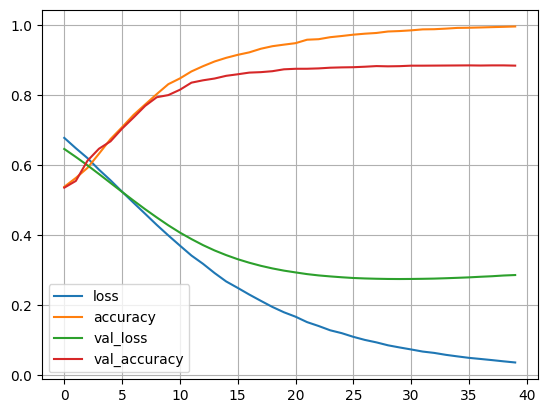

49/49 - 7s - loss: 0.3119 - accuracy: 0.8601 - 7s/epoch - 147ms/step


2024-05-09 19:26:12.572596: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 272202354583925085
2024-05-09 19:26:12.572642: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7081884725511003367
2024-05-09 19:26:12.572653: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13116720455948078591
2024-05-09 19:26:12.572658: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17042561793615019451
2024-05-09 19:26:12.572663: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13235151253668179877
2024-05-09 19:26:12.572669: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 312023397125322854
2024-05-09 19:26:12.572674: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv it

[0.31185975670814514, 0.8600800037384033]

In [14]:
pd.DataFrame(history.history).plot() 
plt.grid(True)
plt.show()
model.evaluate(test_data.shuffle(10000).batch(512),verbose=2)